# RoBERTa Bi-LSTM di Kempok Berita Hiburan

# Install Lib

In [1]:
import nltk
import tensorflow as tf
import numpy as np

import os
import requests
import pandas as pd

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from io import BytesIO
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Init Data

In [2]:
folder_path = '../../All Dataset'
file_name = 'Prepocessed (3).xlsx'
file_path = os.path.join(folder_path, file_name)

df = pd.read_excel(file_path)
df

,id-berita,url,judul,content per paragraf,label-positif,label-persuasif,label-produk,perspektif-tunggal,label-berita,labels,content_lower,content_punct,content_lemma,content_token,content_stopwords
0,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Absen Online kini mulai merambah ke berbagai p...,0,0,1,1,native ads,1,absen online kini mulai merambah ke berbagai p...,absen online kini mulai merambah ke berbagai p...,absen online kini mulai rambah ke bagai usaha ...,"['absen', 'online', 'rambah', 'usaha', 'ganti'...",absen online rambah usaha ganti absen manual r...
1,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Sebelum mengetahui manfaat absen online bagi p...,1,1,1,1,native ads,1,sebelum mengetahui manfaat absen online bagi p...,sebelum mengetahui manfaat absen online bagi p...,belum tahu manfaat absen online bagi usaha mar...,"['manfaat', 'absen', 'online', 'usaha', 'mari'...",manfaat absen online usaha mari ajar erti lapo...
2,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Semua data tersebut selanjutnya akan diberikan...,1,0,1,1,native ads,1,semua data tersebut selanjutnya akan diberikan...,semua data tersebut selanjutnya akan diberikan...,semua data sebut lanjut akan beri kepada hrd y...,"['data', 'hrd', 'tanggung', 'gaji', 'karyawan'...",data hrd tanggung gaji karyawan data hrd rugi ...
3,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,Setiap hari karyawan melakukan absen dengan me...,1,1,0,1,native ads,1,setiap hari karyawan melakukan absen dengan me...,setiap hari karyawan melakukan absen dengan me...,tiap hari karyawan laku absen dengan tulis jam...,"['karyawan', 'laku', 'absen', 'tulis', 'jam', ...",karyawan laku absen tulis jam hadir tanda tang...
4,229,https://tekno.sindonews.com/read/807727/776/pe...,Pengertian Absen Online dan Kelebihannya Diban...,"Sementara, Absen online merupakan sistem absen...",1,1,1,1,native ads,1,"sementara, absen online merupakan sistem absen...","sementara, absen online merupakan sistem absen...",sementara absen online rupa sistem absensi yan...,"['absen', 'online', 'rupa', 'sistem', 'absensi...",absen online rupa sistem absensi manfaat jarin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,Donald Trump yang menjadi lawan Biden sekaligu...,-1,0,0,1,berita murni,0,donald trump yang menjadi lawan biden sekaligu...,donald trump yang menjadi lawan biden sekalig...,donald trump yang jadi lawan biden sekaligus t...,"['donald', 'trump', 'lawan', 'biden', 'tahana'...",donald trump lawan biden tahana coba serang bi...
2498,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,"Dalam utas tersebut, Taibbi mengatakan bahwa a...",0,0,0,1,berita murni,0,"dalam utas tersebut, taibbi mengatakan bahwa a...","dalam utas tersebut, taibbi mengatakan bahwa a...",dalam utas sebut taibbi kata bahwa apa yang ak...,"['utas', 'taibbi', 'baca', 'cuplik', 'buah', '...",utas taibbi baca cuplik buah serial dasar ribu...
2499,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,"Namun menurut Taibbi, Twitter pelan-pelan mala...",-1,0,0,0,berita murni,0,"namun menurut taibbi, twitter pelan-pelan mala...","namun menurut taibbi, twitter pelan-pelan mala...",namun turut taibbi twitter pelan malah tambah ...,"['taibbi', 'twitter', 'pelan', 'halang', 'hala...",taibbi twitter pelan halang halang alat kontro...
2500,998,https://cnnindonesia.com/teknologi/20221203102...,Elon Musk Sebut Twitter Tutupi Cerita Kontrove...,Taibbi juga menyebut sejumlah partai politik m...,-1,0,1,1,berita murni,0,taibbi juga menyebut sejumlah partai politik m...,taibbi juga menyebut sejumlah partai po

## Split dataset

In [3]:

# Load data dari CSV
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

# Ambil X_train dan y_train dari DataFrame
X_train = df_train['content_lemma'].values   # jadi array numpy
y_train = df_train['labels'].values
# Ambil X_test dan y_test dari DataFrame
X_test = df_test['content_lemma'].values   # jadi array numpy
y_test = df_test['labels'].values

In [4]:
y_train_dl = tf.keras.utils.to_categorical(y_train)
y_test_dl = tf.keras.utils.to_categorical(y_test)

(1751, 2)


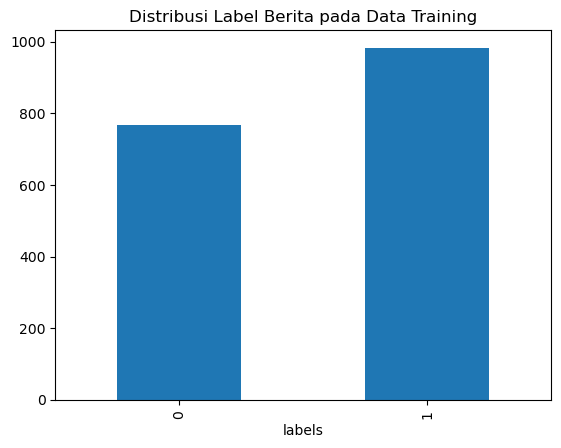

In [5]:
import matplotlib.pyplot as plt

df_train = pd.DataFrame(list(zip(X_train, y_train)), columns=['content_lemma', 'labels'])
df_train.groupby(['labels']).size().plot(kind='bar')
plt.title('Distribusi Label Berita pada Data Training')
print(df_train.shape)

(751, 2)


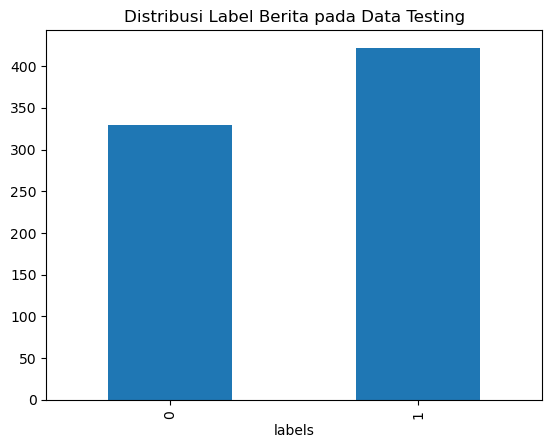

In [6]:
df_test = pd.DataFrame(list(zip(X_test, y_test)), columns=['content_lemma', 'labels'])
df_test.groupby(['labels']).size().plot(kind='bar')
plt.title('Distribusi Label Berita pada Data Testing')
print(df_test.shape)

# Word Embedding (roBERTa)

In [7]:
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = RobertaTokenizer.from_pretrained('cahya/roberta-base-indonesian-522M', do_lower_case=True)
indo_roberta = TFRobertaModel.from_pretrained('cahya/roberta-base-indonesian-522M', from_pt=True)

C:\Users\Asiyah\anaconda3\envs\asiyah_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [8]:
max_len = 257
def encode_texts(text_list):
   # Inisialisasi list untuk menampung hasil
    input_ids = []
    attention_masks = []

    for text in text_list:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Tambahkan [CLS] dan [SEP]
            max_length=max_len,
            padding='max_length',
            truncation=True,  # Aktifkan pemotongan jika teks lebih panjang
            return_tensors='tf',  # Mengembalikan TensorFlow tensors
            return_attention_mask=True  # Menghasilkan attention mask
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return {'input_ids': tf.concat(input_ids, axis=0), 'attention_mask': tf.concat(attention_masks, axis=0)}

In [9]:
# Encode data training dan testing
import tensorflow as tf

train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

In [10]:
# Function to get embeddings with smaller batch size
def get_embeddings(encoded_texts, batch_size=16):
    embeddings = []
    for i in range(0, len(encoded_texts['input_ids']), batch_size):
        batch_input_ids = encoded_texts['input_ids'][i:i+batch_size]
        batch_attention_mask = encoded_texts['attention_mask'][i:i+batch_size]
        outputs = indo_roberta(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)

# Mendapatkan embeddings untuk data training dan testing
train_embeddings = get_embeddings(train_encodings)
test_embeddings = get_embeddings(test_encodings)

In [11]:
from tensorflow.keras.layers import Input
# Input untuk token IDs dan attention mask
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [12]:
# Verifikasi tipe dan shape dari input_ids dan attention_mask
print(f"Type of input_ids: {type(input_ids)}")
print(f"Shape of input_ids: {input_ids.shape}")
print(f"Type of attention_mask: {type(attention_mask)}")
print(f"Shape of attention_mask: {attention_mask.shape}")

Type of input_ids: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape of input_ids: (None, 257)
Type of attention_mask: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Shape of attention_mask: (None, 257)


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from transformers import TFBertModel, BertTokenizer
from transformers.models.bert.modeling_bert import BertLayer

class roBertaLayer(Layer):
    def __init__(self, **kwargs):
        super(roBertaLayer, self).__init__(**kwargs)
        self.indobert = TFRobertaModel.from_pretrained('cahya/roberta-base-indonesian-522M', from_pt=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.indobert(input_ids, attention_mask=attention_mask)
        return output.last_hidden_state

# Definisikan input Keras
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Gunakan BertLayer di dalam model Keras
roberta_output = roBertaLayer()([input_ids, attention_mask])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


# Bi-LSTM

In [14]:
import tensorflow as tf

out = tf.keras.layers.BatchNormalization()(roberta_output)
out = tf.keras.layers.Dropout(0.2)(out)
out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(out)
out = tf.keras.layers.GlobalMaxPooling1D()(out)
out = tf.keras.layers.Dropout(0.2)(out)
y = tf.keras.layers.Dense(2, activation="sigmoid")(out)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)
model.layers[2].trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-05)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 257)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_mask (InputLayer)   │ (None, 257)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ro_berta_layer (roBertaLayer) │ (None, 257, 768)          │               0 │ input_ids[0][0],           │
│                               │                           │                 │ attention_mask[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 257, 768)          │           3,072 │ ro_berta_layer[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 257, 768)          │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 257, 512)          │       2,099,200 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 512)               │               0 │ bidirectional[0][0]        │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ global_max_pooling1d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2)                 │           1,026 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,103,298 (8.02 MB)

 Trainable params: 2,101,762 (8.02 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [15]:
history = model.fit(x={'input_ids':train_encodings['input_ids'], 'attention_mask':train_encodings['attention_mask']},
                    y=y_train_dl,
                    validation_data=(
                        {'input_ids':test_encodings['input_ids'], 'attention_mask':test_encodings['attention_mask']},
                    y_test_dl),
                    epochs=50,
                    batch_size=8)
model.compile()

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1849s 8s/step - balanced_accuracy: 0.6243 - loss: 0.6538 - val_balanced_accuracy: 0.8628 - val_loss: 0.3842
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1898s 9s/step - balanced_accuracy: 0.7980 - loss: 0.4463 - val_balanced_accuracy: 0.8868 - val_loss: 0.3107
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1940s 9s/step - balanced_accuracy: 0.7985 - loss: 0.4120 - val_balanced_accuracy: 0.8921 - val_loss: 0.2830
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1927s 9s/step - balanced_accuracy: 0.8738 - loss: 0.3092 - val_balanced_accuracy: 0.8921 - val_loss: 0.2548
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1966s 9s/step - balanced_accuracy: 0.9046 - loss: 0.2370 - val_balanced_accuracy: 0.8948 - val_loss: 0.2423
Epoch 13/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1987s 9s/step - balanced_accuracy: 0.9049 - loss: 0.2420 - val_balanced_accuracy: 0.9015 - val_loss: 0.2380
Epoch 14/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1932s 9s/step - balanced_accuracy: 0.9568 - loss: 0.1376 - val_balance

## Evaluation Score

In [16]:
# Prediction
from sklearn.metrics import classification_report

predicted_raw = model.predict(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']})

y_pred = np.argmax(predicted_raw, axis=1)
y_true = y_test_dl

# Periksa tipe data
print(f'y_true dtype: {y_true.dtype}, shape: {y_true.shape}')
print(f'y_pred dtype: {y_pred.dtype}, shape: {y_pred.shape}')

# Ubah y_true dari one-hot encoded ke label kelas
if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)

print(classification_report(y_true, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 503s 20s/step
y_true dtype: float64, shape: (751, 2)
y_pred dtype: int64, shape: (751,)
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       329
           1       0.91      0.92      0.92       422

    accuracy                           0.90       751
   macro avg       0.90      0.90      0.90       751
weighted avg       0.90      0.90      0.90       751



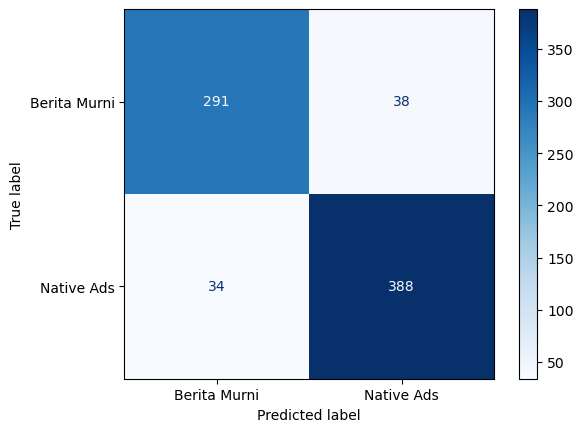

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["Berita Murni", "Native Ads"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score

precision,recall,fscore,support=score(y_true, y_pred,average='macro')
print('Precision : ',format(precision))
print('Recall    : ',format(recall))
print('F-score   : ',format(fscore))
print('Accuracy : ',accuracy_score(y_true, y_pred))

Precision :  0.9030913687251716
Recall    :  0.901964879932007
F-score   :  0.9025012982516878
Accuracy :  0.9041278295605859


## ROC

C:\Users\Asiyah\anaconda3\envs\asiyah_env\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


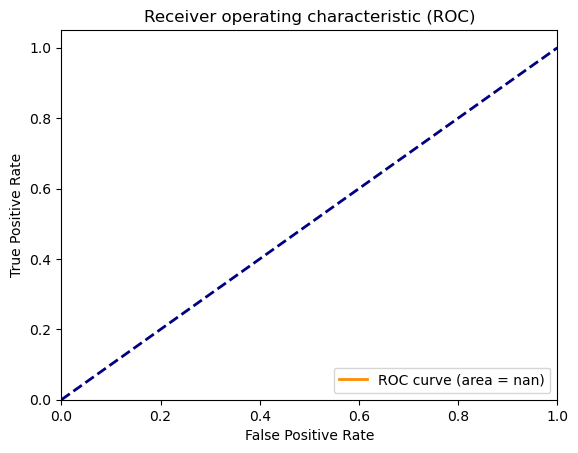

In [19]:
import numpy as np
from sklearn import metrics

y = np.array(y_true)

scores = np.array(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [20]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true, y_pred)
auc_rf = auc(fpr_rf, tpr_rf)

In [21]:
auc_rf

0.9019648799320071

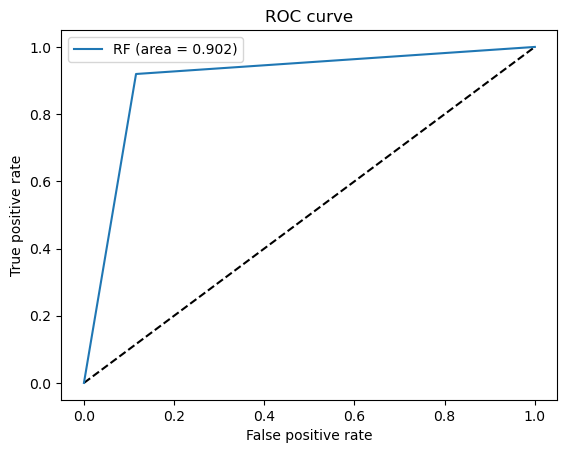

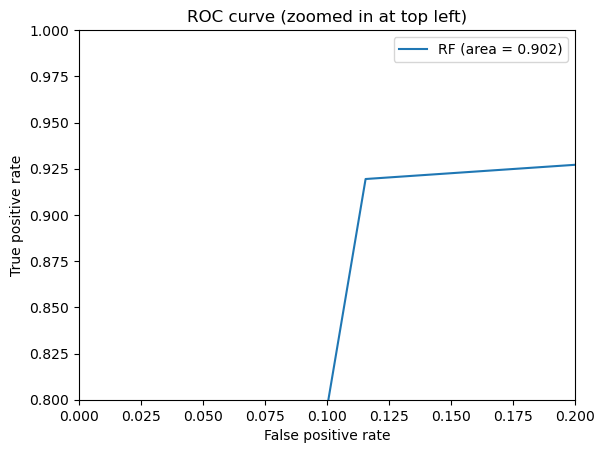

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [23]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

In [24]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (y_true, y_pred)

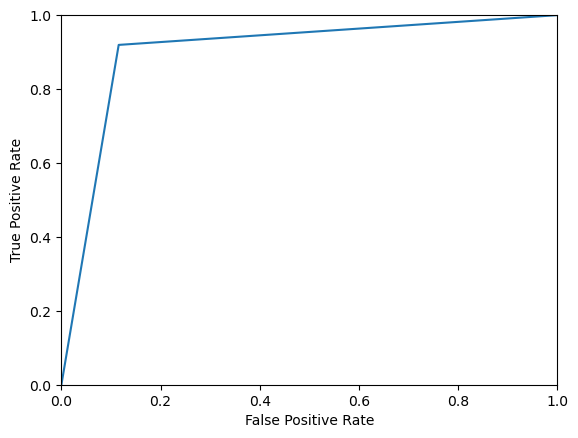

In [25]:
plot_roc_curve (fpr,tpr)

In [26]:
roc_auc_score(y_true, y_pred)

0.9019648799320071

0.9019648799320071


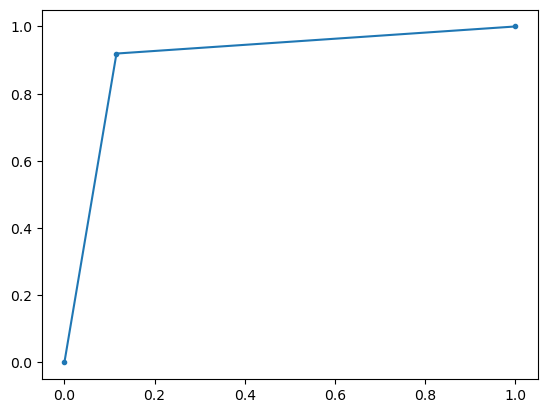

In [27]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
print(auc_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [28]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [29]:
perf_measure(y_true, y_pred)

(388, 38, 291, 34)

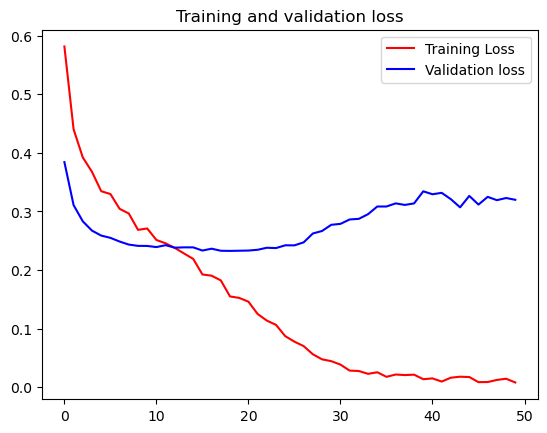

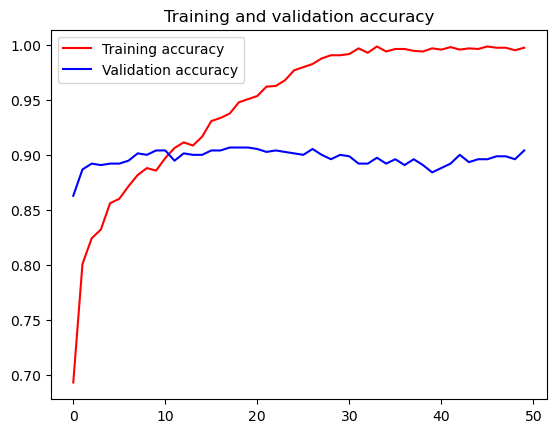

<Figure size 640x480 with 0 Axes>

In [30]:
acc = history.history['balanced_accuracy']
val_acc = history.history['val_balanced_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Menampilkan data yang salah di deteksi

In [31]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    TP_indices = []
    TN_indices = []
    FP_indices = []
    FN_indices = []

    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
            TP_indices.append(i)
        elif y_hat[i] == 1 and y_actual[i] != y_hat[i]:  # False Positive
            FP += 1
            FP_indices.append(i)
        elif y_actual[i] == y_hat[i] == 0:
            TN += 1
            TN_indices.append(i)
        elif y_hat[i] == 0 and y_actual[i] != y_hat[i]:  # False Negative
            FN += 1
            FN_indices.append(i)

    return TP, FP, TN, FN, TP_indices, FP_indices, TN_indices, FN_indices

In [32]:
# Calculate the performance metrics and retrieve indices 
TP, FP, TN, FN, TP_indices, FP_indices, TN_indices, FN_indices = perf_measure(y_true, y_pred)

# Select the FP and FN data from the dataset
FP_data = df.iloc[FP_indices][['id-berita', 'url', 'content per paragraf', 'content_stopwords']]
FN_data = df.iloc[FN_indices][['id-berita', 'url', 'content per paragraf', 'content_stopwords']]

In [33]:
# Display the results
print("False Positives (FP):")
print(FP_data)
print('Jumlah dari FP adalah',len(FP_data), 'paragraf.')

print("\nFalse Negatives (FN):")
print(FN_data)
print('Jumlah dari FN adalah',len(FN_data), 'paragraf.')

False Positives (FP):
     id-berita                                                url  \
6          229  https://tekno.sindonews.com/read/807727/776/pe...   
20         231  https://tekno.sindonews.com/read/799655/776/ma...   
25         232  https://tekno.sindonews.com/read/799617/776/se...   
37         235  https://tekno.sindonews.com/read/787787/776/zi...   
59         240  https://tekno.sindonews.com/read/757169/776/in...   
140        253  https://tekno.sindonews.com/read/741011/776/hu...   
145        253  https://tekno.sindonews.com/read/741011/776/hu...   
155        254  https://tekno.sindonews.com/read/734955/776/ac...   
158        254  https://tekno.sindonews.com/read/734955/776/ac...   
182        256  https://tekno.sindonews.com/read/715303/776/ga...   
183        256  https://tekno.sindonews.com/read/715303/776/ga...   
223        260  https://tekno.sindonews.com/read/702041/776/as...   
226        260  https://tekno.sindonews.com/read/702041/776/as...   
228        2

In [34]:
import os
# Specify the folder path
folder_path = 'E:/Asiyah/tesis/Thesis Persuasive Detection at Paragraph-Level/Mine/4 Terbaik (70-30)/Salah deteksi'  # Replace this with your desired folder path

# Full paths for saving files
fp_file_path = os.path.join(folder_path, 'FP_RoBERTa-BiLSTM-Biner.csv')
fn_file_path = os.path.join(folder_path, 'FN_RoBERTa-BiLSTM-Biner.csv')

# Save FP_data and FN_data to CSV files within the specified folder
FP_data.to_csv(fp_file_path, index=False)
FN_data.to_csv(fn_file_path, index=False)


## FP& FN

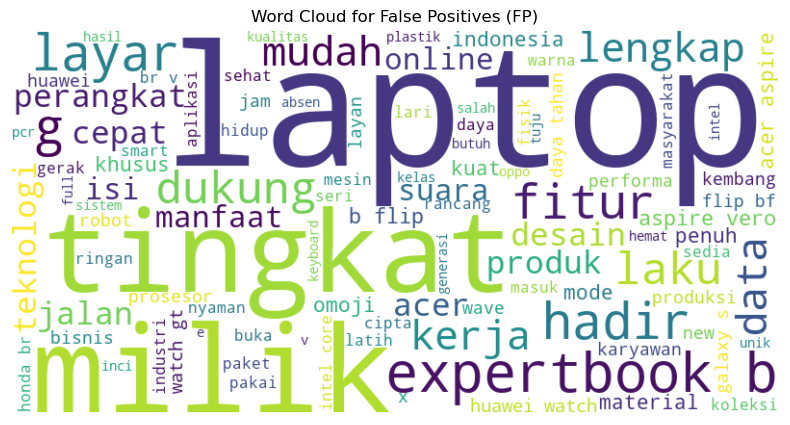

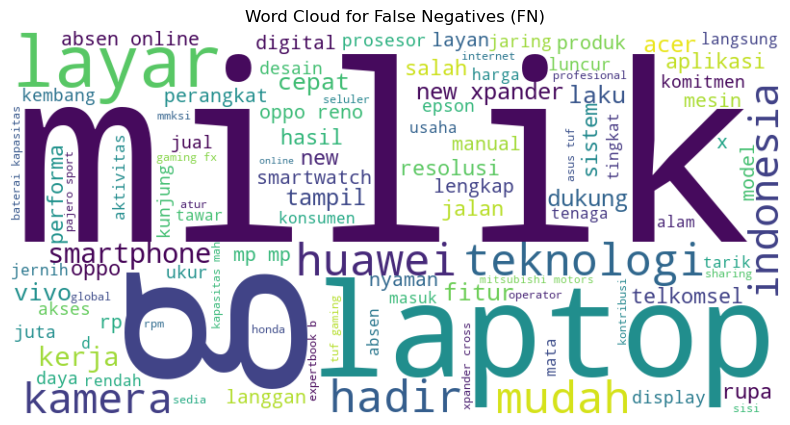

In [37]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan semua teks dalam kolom 'content per paragraf' untuk FP dan FN
fp_text = " ".join(paragraph for paragraph in FP_data['content_stopwords'])
fn_text = " ".join(paragraph for paragraph in FN_data['content_stopwords'])

# Fungsi untuk membuat dan menampilkan word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Membuat word cloud untuk False Positives
plot_wordcloud(fp_text, "Word Cloud for False Positives (FP)")

# Membuat word cloud untuk False Negatives
plot_wordcloud(fn_text, "Word Cloud for False Negatives (FN)")

## TP & TN

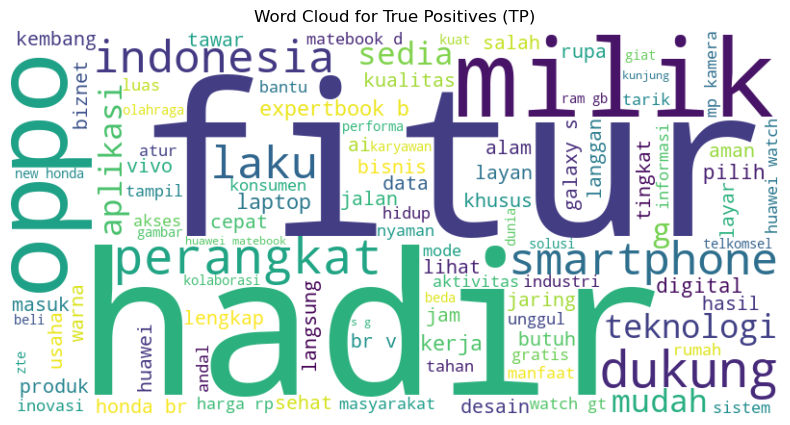

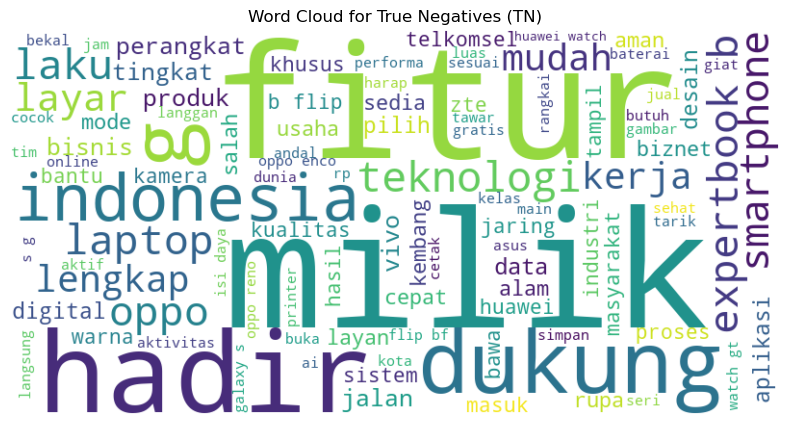

In [38]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil data TP dan TN dari dataset
TP_data = df.iloc[TP_indices]['content_stopwords']
TN_data = df.iloc[TN_indices]['content_stopwords']

# Gabungkan teks dari TP dan TN
tp_text = " ".join(paragraph for paragraph in TP_data)
tn_text = " ".join(paragraph for paragraph in TN_data)

# Fungsi untuk membuat dan menampilkan word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Membuat word cloud untuk True Positives
plot_wordcloud(tp_text, "Word Cloud for True Positives (TP)")

# Membuat word cloud untuk True Negatives
plot_wordcloud(tn_text, "Word Cloud for True Negatives (TN)")
